## Previous application training

This notebook attempts to exploit the correlation between previous application and current defaulting rate. We have each training sample being one previous application, and target being the corresponding current target --- previous applications belonging to the same customer will all use this customer's current target. We then use LightGBM classifier with auc loss to predict the probability of each previous application belonging to a customer who has defaulted loan currently. When the model is trained, the prediction (a probability within (0,1)) is grouped by the current customer ID, and statistics such as mean/sum are computed. These statistics are saved to disk to be merged to the main training table.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

from lightgbm import LGBMClassifier, LGBMRegressor
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("../input"))
    
gc.enable()

c:\Users\Paintaker\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'download_command.txt', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [2]:
data = pd.read_csv('../input/application_train.csv', usecols=['SK_ID_CURR','TARGET'])

In [5]:
#agg_month_score = pd.read_csv('../output/agg_month_score.csv',compression='zip')

In [6]:
#agg_month_score

,SK_ID_CURR,month_score_std,month_score_sum,month_score_max,month_score_mean,TARGET
0,100001,0.012817,0.050939,0.063049,0.001592,NaN
1,100002,0.020830,0.557779,0.049850,0.012395,1.0
2,100003,0.013076,-0.308702,0.019917,-0.013422,0.0
3,100004,0.007023,0.000806,0.009370,0.000202,0.0
4,100005,0.012978,0.242749,0.057308,0.010554,NaN
...,...,...,...,...,...,...
343634,456251,0.013337,0.225342,0.049177,0.025038,0.0
343635,456252,0.003710,-0.078255,-0.006081,-0.011179,0.0
343636,456253,0.005117,-0.032935,0.009645,-0.000867,0.0
343637,456254,0.021230,0.000893,0.075015,0.000047,1.0


In [3]:
data

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0
...,...,...
307506,456251,0
307507,456252,0
307508,456253,0
307509,456254,1


Create features for each previous application,such as ratio between credit applied in debt and credit granted, ratio between credit granted and annuity, expected time to payoff the loan, amount left to pay at the time of current application, difference between actual and expected last payment date. 

In [4]:
prev = pd.read_csv('../input/previous_application.csv')
prev = prev.loc[prev['FLAG_LAST_APPL_PER_CONTRACT']=='Y'] #mistake rows
del prev['FLAG_LAST_APPL_PER_CONTRACT']

#replace strange number of days as nan
for f_ in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    prev[f_].loc[prev[f_]>360000] = np.nan

#create some features
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
prev['AMT_DIFF_CREAPP'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['AMT_DIFF_CREDIT_GOODS'] = prev['AMT_CREDIT'] - prev['AMT_GOODS_PRICE']
prev['AMT_CREDIT_GOODS_PERC'] = prev['AMT_CREDIT'] / prev['AMT_GOODS_PRICE']
prev['AMT_PAY_YEAR'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']
prev['DAYS_TOTAL'] = prev['DAYS_LAST_DUE'] - prev['DAYS_FIRST_DUE']
prev['DAYS_TOTAL2'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_FIRST_DUE']
prev['AMT_LEFT'] = (prev['AMT_CREDIT'] - prev['AMT_ANNUITY'] * prev['DAYS_LAST_DUE_1ST_VERSION']/365.25).clip(lower=0)
prev['PAYMENT_LEFT'] = prev['AMT_LEFT']/prev['AMT_ANNUITY']

#these features highly correlated with others or not useful?
rejected_features = ['AMT_GOODS_PRICE',
                     'WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START',
                     'NFLAG_LAST_APPL_IN_DAY']
for f_ in rejected_features:
    del prev[f_]
    
#Label Encoding
categorical_feats = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]

for f_ in categorical_feats:
    nunique = prev[f_].nunique(dropna=False)
    print(f_,nunique,prev[f_].unique())
    prev[f_], indexer = pd.factorize(prev[f_])
    
prev.head()

NAME_CONTRACT_TYPE 4 ['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']
NAME_CASH_LOAN_PURPOSE 25 ['XAP' 'XNA' 'Repairs' 'Everyday expenses' 'Car repairs'
 'Building a house or an annex' 'Other' 'Journey'
 'Purchase of electronic equipment' 'Medicine' 'Payments on other loans'
 'Urgent needs' 'Buying a used car' 'Buying a new car'
 'Buying a holiday home / land' 'Education' 'Buying a home' 'Furniture'
 'Buying a garage' 'Business development' 'Wedding / gift / holiday'
 'Hobby' 'Gasification / water supply' 'Refusal to name the goal'
 'Money for a third person']
NAME_CONTRACT_STATUS 4 ['Approved' 'Refused' 'Canceled' 'Unused offer']
NAME_PAYMENT_TYPE 4 ['Cash through the bank' 'XNA' 'Non-cash from your account'
 'Cashless from the account of the employer']
CODE_REJECT_REASON 9 ['XAP' 'HC' 'LIMIT' 'CLIENT' 'SCOFR' 'SCO' 'XNA' 'VERIF' 'SYSTEM']
NAME_TYPE_SUITE 8 [nan 'Unaccompanied' 'Spouse, partner' 'Family' 'Children' 'Other_B'
 'Other_A' 'Group of people']
NAME_CLIENT_TYPE 4 ['Re

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,...,NFLAG_INSURED_ON_APPROVAL,APP_CREDIT_PERC,AMT_DIFF_CREAPP,AMT_DIFF_CREDIT_GOODS,AMT_CREDIT_GOODS_PERC,AMT_PAY_YEAR,DAYS_TOTAL,DAYS_TOTAL2,AMT_LEFT,PAYMENT_LEFT
0,2030495,271877,0,1730.430,17145.0,17145.0,0.0,0.0,0.182832,0.867336,...,0.0,1.000000,0.0,0.0,1.00000,9.907942,0.0,342.0,15723.702259,9.086587
1,2802425,108129,1,25188.615,607500.0,679671.0,NaN,NaN,NaN,NaN,...,1.0,0.893815,-72171.0,72171.0,1.11880,26.983262,NaN,1050.0,616501.194825,24.475391
2,2523466,122040,1,15060.735,112500.0,136444.5,NaN,NaN,NaN,NaN,...,1.0,0.824511,-23944.5,23944.5,1.21284,9.059618,NaN,330.0,134011.691335,8.898084
3,2819243,176158,1,47041.335,450000.0,470790.0,NaN,NaN,NaN,NaN,...,1.0,0.955840,-20790.0,20790.0,1.04620,10.008007,300.0,330.0,490366.407721,10.424160
4,1784265,202054,1,31924.395,337500.0,404055.0,NaN,NaN,NaN,NaN,...,NaN,0.835282,-66555.0,66555.0,1.19720,12.656622,NaN,NaN,NaN,NaN


Aggragate the installment features for each buro record. Some new features are difference between expected and actural payment amount, difference between expected and actural payment date, last time DPD.

Then compute stats (mean/max/sum...) of these new and raw features over time.

In [5]:
inst = pd.read_csv('../input/installments_payments.csv')
inst_NUM_INSTALMENT_VERSION = inst.groupby(['SK_ID_PREV'])['NUM_INSTALMENT_VERSION'].nunique()

#merge payments of same month
#maybe helpful for: inst.loc[(inst.SK_ID_PREV==1000005) & (inst.SK_ID_CURR==176456) & (inst.NUM_INSTALMENT_NUMBER==9)]
inst['DAYS_ENTRY_PAYMENT_weighted'] = inst['DAYS_ENTRY_PAYMENT'] * inst['AMT_PAYMENT']
inst['MONTHS_BALANCE'] = (inst['DAYS_INSTALMENT']/30.4375).astype('int')
inst = inst.groupby(['SK_ID_PREV','SK_ID_CURR','MONTHS_BALANCE']).agg({'DAYS_INSTALMENT':'mean',
                                                                       'DAYS_ENTRY_PAYMENT_weighted':'sum',
                                                                       'AMT_INSTALMENT':'mean',
                                                                       'AMT_PAYMENT':'sum'})
inst['DAYS_ENTRY_PAYMENT'] = inst['DAYS_ENTRY_PAYMENT_weighted']/inst['AMT_PAYMENT']
inst = inst.reset_index()
del inst['DAYS_ENTRY_PAYMENT_weighted']
inst.head()

inst['AMT_PAYMENT_PERC'] = inst['AMT_PAYMENT'] / (1+inst['AMT_INSTALMENT'])
inst['AMT_PAYMENT_DIFF'] = inst['AMT_PAYMENT'] - inst['AMT_INSTALMENT']
inst['DPD'] = (inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']).clip(lower=0)
inst['DBD'] = (inst['DAYS_INSTALMENT'] - inst['DAYS_ENTRY_PAYMENT']).clip(lower=0)
inst['DPD'].fillna(30,inplace=True)
inst['DBD'].fillna(0,inplace=True)

#when is the last time late
inst_last_late = inst[inst.DAYS_INSTALMENT < inst.DAYS_ENTRY_PAYMENT].groupby(['SK_ID_PREV'])['DAYS_INSTALMENT'].max()
inst_last_late.rename('DAYS_LAST_LATE',inplace=True)

#when is the last time underpaid
inst_last_underpaid = inst[inst.AMT_INSTALMENT < inst.AMT_PAYMENT].groupby(['SK_ID_PREV'])['DAYS_INSTALMENT'].max()
inst_last_underpaid.rename('DAYS_LAST_UNDERPAID',inplace=True)

num_aggregations = {
    'MONTHS_BALANCE': ['size','min','max'],
    'AMT_PAYMENT_PERC': ['max','mean','var'],
    'AMT_PAYMENT_DIFF': [ 'sum', 'mean','var'],
    'AMT_PAYMENT': [ 'sum','mean','var'],
    'DPD': ['sum', 'max','mean','var'],
    'DBD': ['sum', 'max','mean','var'],
}
inst = inst.groupby('SK_ID_PREV').agg(num_aggregations)
inst.columns = pd.Index([e[0] + "_" + e[1].upper() for e in inst.columns.tolist()])
inst['N_NUM_INSTALMENT_VERSION'] = inst_NUM_INSTALMENT_VERSION
inst['DAYS_LAST_LATE'] = inst_last_late
inst['DAYS_LAST_UNDERPAID'] = inst_last_underpaid
inst = inst.add_prefix('inst_')
inst.head()

,inst_MONTHS_BALANCE_SIZE,inst_MONTHS_BALANCE_MIN,inst_MONTHS_BALANCE_MAX,inst_AMT_PAYMENT_PERC_MAX,inst_AMT_PAYMENT_PERC_MEAN,inst_AMT_PAYMENT_PERC_VAR,inst_AMT_PAYMENT_DIFF_SUM,inst_AMT_PAYMENT_DIFF_MEAN,inst_AMT_PAYMENT_DIFF_VAR,inst_AMT_PAYMENT_SUM,...,inst_DPD_MAX,inst_DPD_MEAN,inst_DPD_VAR,inst_DBD_SUM,inst_DBD_MAX,inst_DBD_MEAN,inst_DBD_VAR,inst_N_NUM_INSTALMENT_VERSION,inst_DAYS_LAST_LATE,inst_DAYS_LAST_UNDERPAID
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,
1000001,2,-8,-7,0.999984,0.999914,9.800261e-09,0.000000e+00,0.000000e+00,0.000000e+00,68443.425,...,0.000000,0.00000,0.000000,32.0,26.0,16.000000,200.000000,2,NaN,NaN
1000002,4,-52,-49,0.999946,0.999867,2.777311e-09,0.000000e+00,0.000000e+00,0.000000e+00,37235.565,...,0.000000,0.00000,0.000000,79.0,44.0,19.750000,294.250000,2,NaN,NaN
1000003,3,-3,-1,0.999798,0.999798,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,14854.050,...,0.000000,0.00000,0.000000,46.0,17.0,15.333333,2.333333,1,NaN,NaN
1000004,7,-28,-22,0.999924,0.999736,6.846242e-09,0.000000e+00,0.000000e+00,0.000000e+00,33523.155,...,0.000000,0.00000,0.000000,187.0,58.0,26.714286,290.571429,2,NaN,NaN
1000005,10,-55,-46,0.999932,0.999932,2.832800e-14,1.818989e-12,1.818989e-13,3.308722e-25,147021.705,...,2.992605,0.39926,0.929066,61.0,15.0,6.100000,18.544444,1,-1448.0,-1448.0


Aggragate the pos cash features for each buro record.

In [6]:
pos = pd.read_csv('../input/POS_CASH_balance.csv')
idx = pos.groupby(['SK_ID_PREV'])['MONTHS_BALANCE'].idxmax() #most recent data
pos_recent = pos[['SK_ID_PREV','MONTHS_BALANCE','CNT_INSTALMENT','CNT_INSTALMENT_FUTURE',
                  'NAME_CONTRACT_STATUS','SK_DPD','SK_DPD_DEF']].loc[idx.values]
pos_recent['NAME_CONTRACT_STATUS'],indexer = pd.factorize(pos_recent['NAME_CONTRACT_STATUS'])
pos_recent.set_index('SK_ID_PREV',inplace=True)
pos_recent.columns = ['pos_recent_' + f_ for f_ in pos_recent.columns]

#what is the last month with DPD
pos_last_DPD = pos[pos.SK_DPD>0].groupby(['SK_ID_PREV'])['MONTHS_BALANCE'].max()
pos_last_DPD.rename('MONTH_LAST_DPD',inplace=True)

pos['has_DPD'] = 0
pos['has_DPD'].loc[pos['SK_DPD']>0] = 1
num_aggregations = {
    'MONTHS_BALANCE': ['size'],
    'has_DPD': ['sum','mean'],
    'SK_DPD': ['max','mean'],
    'SK_DPD_DEF': [ 'sum', 'median'],
}
pos = pos.groupby('SK_ID_PREV').agg(num_aggregations)
pos.columns = pd.Index(['pos_' + e[0] + "_" + e[1].upper() for e in pos.columns.tolist()])
pos = pos.merge(pos_recent, how='outer', on='SK_ID_PREV')

pos['MONTH_LAST_DPD'] = pos_last_DPD
del pos_recent
gc.collect
pos.head()

c:\Users\Paintaker\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,pos_MONTHS_BALANCE_SIZE,pos_has_DPD_SUM,pos_has_DPD_MEAN,pos_SK_DPD_MAX,pos_SK_DPD_MEAN,pos_SK_DPD_DEF_SUM,pos_SK_DPD_DEF_MEDIAN,pos_recent_MONTHS_BALANCE,pos_recent_CNT_INSTALMENT,pos_recent_CNT_INSTALMENT_FUTURE,pos_recent_NAME_CONTRACT_STATUS,pos_recent_SK_DPD,pos_recent_SK_DPD_DEF,MONTH_LAST_DPD
SK_ID_PREV,,,,,,,,,,,,,,
1000001,3,0,0.0,0,0.0,0,0.0,-8,2.0,0.0,0,0,0,NaN
1000002,5,0,0.0,0,0.0,0,0.0,-50,4.0,0.0,0,0,0,NaN
1000003,4,0,0.0,0,0.0,0,0.0,-1,12.0,9.0,1,0,0,NaN
1000004,8,0,0.0,0,0.0,0,0.0,-22,7.0,0.0,0,0,0,NaN
1000005,11,0,0.0,0,0.0,0,0.0,-46,10.0,0.0,0,0,0,NaN


In [7]:
pos.shape

(936325, 14)

Aggragate the credit card features for each buro record.

In [8]:
ccbl = pd.read_csv('../input/credit_card_balance.csv')
ccbl['AMT_BALANCE_CREDIT_RATIO'] = (ccbl['AMT_BALANCE']/(ccbl['AMT_CREDIT_LIMIT_ACTUAL']+0.001)).clip(-100,100)
ccbl['AMT_CREDIT_USE_RATIO'] = (ccbl['AMT_DRAWINGS_CURRENT']/(ccbl['AMT_CREDIT_LIMIT_ACTUAL']+0.001)).clip(-100,100)
ccbl['AMT_DRAWING_ATM_RATIO'] = ccbl['AMT_DRAWINGS_ATM_CURRENT']/(ccbl['AMT_DRAWINGS_CURRENT']+0.001)
ccbl['AMT_PAY_USE_RATIO'] = ((ccbl['AMT_PAYMENT_TOTAL_CURRENT']+0.001)/(ccbl['AMT_DRAWINGS_CURRENT']+0.001)).clip(-100,100)
ccbl['AMT_BALANCE_RECIVABLE_RATIO'] = ccbl['AMT_BALANCE']/(ccbl['AMT_TOTAL_RECEIVABLE']+0.001)
ccbl['AMT_DRAWING_BALANCE_RATIO'] = ccbl['AMT_DRAWINGS_CURRENT']/(ccbl['AMT_BALANCE']+0.001)
ccbl['AMT_RECEIVABLE_PRINCIPAL_DIFF'] = ccbl['AMT_TOTAL_RECEIVABLE']-ccbl['AMT_RECEIVABLE_PRINCIPAL']
ccbl['AMT_PAY_INST_DIFF'] = ccbl['AMT_PAYMENT_CURRENT'] - ccbl['AMT_INST_MIN_REGULARITY']

rejected_features = ['AMT_RECIVABLE','AMT_RECEIVABLE_PRINCIPAL',
                     'AMT_DRAWINGS_POS_CURRENT']
for f_ in rejected_features:
    del ccbl[f_]

ccbl_last_DPD = ccbl[ccbl.SK_DPD>0].groupby(['SK_ID_CURR'])['MONTHS_BALANCE'].max()
ccbl_last_DPD.rename('MONTH_LAST_DPD',inplace=True)

sum_feats = [f_ for f_ in ccbl.columns.values[3:] if (f_.find('RATIO')==-1) & (f_.find('CNT')==-1)]
print ('sum_feats', sum_feats)
ccbl_sum =  ccbl.groupby('SK_ID_PREV')[sum_feats].sum()
ccbl_sum = ccbl_sum.add_prefix('sum_')

mean_feats = [f_ for f_ in ccbl.columns.values[3:]]
print ('mean_feats', mean_feats)
ccbl_mean = ccbl.groupby('SK_ID_PREV')[mean_feats].mean()
ccbl_mean = ccbl_mean.add_prefix('mean_')

ccbl = ccbl_mean.merge(ccbl_sum, how='outer', on='SK_ID_PREV')

ccbl['last_DPD'] = ccbl_last_DPD
ccbl = ccbl.add_prefix('cc_')
del ccbl_mean, ccbl_sum
gc.collect()
ccbl.head()

sum_feats ['AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_TOTAL_RECEIVABLE', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF', 'AMT_RECEIVABLE_PRINCIPAL_DIFF', 'AMT_PAY_INST_DIFF']
mean_feats ['AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF', 'AMT_BALANCE_CREDIT_RATIO', 'AMT_CREDIT_USE_RATIO', 'AMT_DRAWING_ATM_RATIO', 'AMT_PAY_USE_RATIO', 'AMT_BALANCE_RECIVABLE_RATIO', 'AMT_DRAWING_BALANCE_RATIO', 'AMT_RECEIVABLE_PRINCIPAL_DIFF', 'AMT_PAY_INST_DIFF']


,cc_mean_AMT_BALANCE,cc_mean_AMT_CREDIT_LIMIT_ACTUAL,cc_mean_AMT_DRAWINGS_ATM_CURRENT,cc_mean_AMT_DRAWINGS_CURRENT,cc_mean_AMT_DRAWINGS_OTHER_CURRENT,cc_mean_AMT_INST_MIN_REGULARITY,cc_mean_AMT_PAYMENT_CURRENT,cc_mean_AMT_PAYMENT_TOTAL_CURRENT,cc_mean_AMT_TOTAL_RECEIVABLE,cc_mean_CNT_DRAWINGS_ATM_CURRENT,...,cc_sum_AMT_DRAWINGS_OTHER_CURRENT,cc_sum_AMT_INST_MIN_REGULARITY,cc_sum_AMT_PAYMENT_CURRENT,cc_sum_AMT_PAYMENT_TOTAL_CURRENT,cc_sum_AMT_TOTAL_RECEIVABLE,cc_sum_SK_DPD,cc_sum_SK_DPD_DEF,cc_sum_AMT_RECEIVABLE_PRINCIPAL_DIFF,cc_sum_AMT_PAY_INST_DIFF,cc_last_DPD
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,
1000018,74946.285000,81000.000000,5400.000000,29478.996000,0.0,2594.088000,5541.750000,5541.750000,73602.585000,1.200000,...,0.0,12970.44,27708.75,27708.75,368012.925,0,0,6521.940,14738.31,NaN
1000030,55991.064375,81562.500000,642.857143,17257.438125,0.0,2078.223750,6188.631429,2657.947500,55935.376875,0.142857,...,0.0,16625.79,43320.42,21263.58,447483.015,0,0,3687.390,26694.63,NaN
1000031,52394.439375,149625.000000,12115.384615,28959.615000,0.0,2675.300625,29543.257500,22157.443125,52099.970625,0.307692,...,0.0,42804.81,354519.09,354519.09,833599.530,0,0,11153.475,311714.28,NaN
1000035,0.000000,225000.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN,...,0.0,0.00,0.00,0.00,0.000,0,0,0.000,0.00,NaN
1000077,0.000000,94090.909091,NaN,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN,...,0.0,0.00,0.00,0.00,0.000,0,0,0.000,0.00,NaN


Merge installment, pos cash, credit card features to the main previous application table:

In [9]:
prev_meta = prev.merge(inst, on='SK_ID_PREV', how='left')
prev_meta = prev_meta.merge(pos, on='SK_ID_PREV', how='left')
prev_meta = prev_meta.merge(ccbl, on='SK_ID_PREV', how='left')
del inst, pos, ccbl
gc.collect()
prev_meta.shape

(1661739, 116)

Create a few more features:

In [10]:
interest_tmp = prev_meta['RATE_INTEREST_PRIVILEGED'].fillna(0)
downpayment_tmp = prev_meta['AMT_DOWN_PAYMENT'].fillna(0)
inst_AMT_PAYMENT_SUM_tmp = prev_meta['inst_AMT_PAYMENT_SUM'].fillna(0)
prev_meta['AMT_LEFT2'] = (prev_meta['AMT_CREDIT']-downpayment_tmp)*(1+interest_tmp) - inst_AMT_PAYMENT_SUM_tmp
prev_meta['AMT_LEFT2'] = prev_meta['AMT_LEFT2'].clip(lower=0)
prev_meta['AMT_LEFT2'].loc[prev_meta['NAME_CONTRACT_STATUS']!=0] = 0
prev_meta['PAYMENT_CREDIT_RATIO'] = prev_meta['inst_AMT_PAYMENT_SUM']/prev_meta['AMT_CREDIT']
prev_meta['AMT_LEFT3'] = prev_meta['AMT_CREDIT'] * prev_meta['pos_recent_CNT_INSTALMENT']/ (prev_meta['pos_recent_CNT_INSTALMENT_FUTURE'] + prev_meta['pos_recent_CNT_INSTALMENT'])

c:\Users\Paintaker\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
prev_meta.shape

(1661739, 119)

Broadcast current target to previous applications, according to the current ID each previous application correspond to.

In [12]:
target_map = pd.Series(data.TARGET.values, index=data.SK_ID_CURR.values)
y = prev_meta['SK_ID_CURR'].map(target_map)

In [15]:
target_map

100002    1
100003    0
100004    0
100006    0
100007    0
         ..
456251    0
456252    0
456253    0
456254    1
456255    0
Length: 307511, dtype: int64

In [18]:
y

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1661734    NaN
1661735    NaN
1661736    0.0
1661737    0.0
1661738    0.0
Name: SK_ID_CURR, Length: 1661739, dtype: float64

Split train and test set (test set are those without target)

In [16]:
train_x = prev_meta.loc[~y.isnull()]
test_x = prev_meta.loc[y.isnull()]
train_y = y.loc[~y.isnull()]

In [17]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)

(1406387, 119)
(255352, 119)
(1406387,)


In [21]:
len(train_x.columns)

119

In [24]:
excluded_feats = ['SK_ID_CURR','SK_ID_PREV']
features = [f_ for f_ in train_x.columns.values if not f_ in excluded_feats]
print(len(features))

train_x = prev_meta.loc[~y.isnull()]
test_x = prev_meta.loc[y.isnull()]
train_y = y.loc[~y.isnull()]

# Run a 5 fold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
oof_preds = np.zeros(train_x.shape[0])
sub_preds = np.zeros(test_x.shape[0])
feature_importance_df = pd.DataFrame()

117


In [25]:
train_x

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,...,cc_sum_AMT_PAYMENT_TOTAL_CURRENT,cc_sum_AMT_TOTAL_RECEIVABLE,cc_sum_SK_DPD,cc_sum_SK_DPD_DEF,cc_sum_AMT_RECEIVABLE_PRINCIPAL_DIFF,cc_sum_AMT_PAY_INST_DIFF,cc_last_DPD,AMT_LEFT2,PAYMENT_CREDIT_RATIO,AMT_LEFT3
0,2030495,271877,0,1730.430,17145.0,17145.0,0.0,0.000000,0.182832,0.867336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14731.20333,1.008123,17145.000000
1,2802425,108129,1,25188.615,607500.0,679671.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,553727.92500,0.185300,359825.823529
2,2523466,122040,1,15060.735,112500.0,136444.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,897.88500,0.993419,109155.600000
3,2819243,176158,1,47041.335,450000.0,470790.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,1.196146,470790.000000
4,1784265,202054,1,31924.395,337500.0,404055.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661732,1662353,443544,1,12607.875,112500.0,112500.0,0.0,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN
1661733,1556789,209732,1,22299.390,315000.0,436216.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,1.412298,436216.500000
1661736,2659632,249544,0,11520.855,105237.0,102523.5,10525.5,0.101401,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,1.123533,102523.500000
1661737,2785582,400317,1,18821.520,180000.0,191880.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,1.176958,191880.000000


Train LightGBM classifier

In [26]:
scores = []

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_x, train_y)):
    trn_x, val_x = train_x[features].iloc[trn_idx], train_x[features].iloc[val_idx]
    trn_y, val_y = train_y.iloc[trn_idx], train_y.iloc[val_idx]
    
    clf = LGBMClassifier(
        n_estimators=5000,
        learning_rate=0.05,
        num_leaves=20,
        metric = 'auc',
        colsample_bytree=0.3,
        subsample=0.9,
        max_depth=5,
        reg_alpha=5,
        reg_lambda=4,
        min_split_gain=0.002,
        min_child_weight=40,
        silent=True,
        verbose=-1,
        n_jobs = 16,
        random_state = n_fold * 619,
        scale_pos_weight = 2
    )
    
    clf.fit(trn_x, trn_y, 
            eval_set= [(val_x, val_y)], 
            eval_metric='auc',
            categorical_feature = categorical_feats,
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x)[:, 1]
    sub_preds += clf.predict_proba(test_x[features])[:, 1] / folds.n_splits
    
    fold_score = roc_auc_score(val_y, oof_preds[val_idx])
    scores.append(fold_score)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, fold_score))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f +- %0.4f' % (roc_auc_score(train_y, oof_preds), np.std(scores)))

Fold  1 AUC : 0.634451
Fold  2 AUC : 0.638532
Fold  3 AUC : 0.633055
Fold  4 AUC : 0.633629
Fold  5 AUC : 0.633852
Full AUC score 0.634685 +- 0.0020


In [34]:
print(len(oof_preds))
print(len(sub_preds))

1406387
255352


Get prediction for each previous application -- giving each previous application a score, which measures how likely it belongs to a user who has defaulting account currently.

In [36]:
train_x[['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']]

,SK_ID_CURR,SK_ID_PREV,DAYS_DECISION
0,271877,2030495,-73
1,108129,2802425,-164
2,122040,2523466,-301
3,176158,2819243,-512
4,202054,1784265,-781
...,...,...,...
1661732,443544,1662353,-2514
1661733,209732,1556789,-1279
1661736,249544,2659632,-1488
1661737,400317,2785582,-1185


In [37]:
train_prev_score = train_x[['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']]
train_prev_score['score'] = oof_preds
test_prev_score = test_x[['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']]
test_prev_score['score'] = sub_preds
prev_score = pd.concat([train_prev_score,test_prev_score])
prev_score.to_csv('../output/prev_score.csv',index=False,compression='zip')

C:\Users\PAINTA~1\AppData\Local\Temp/ipykernel_3648/1044294593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prev_score['score'] = oof_preds
C:\Users\PAINTA~1\AppData\Local\Temp/ipykernel_3648/1044294593.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prev_score['score'] = sub_preds


In [38]:
prev_score

,SK_ID_CURR,SK_ID_PREV,DAYS_DECISION,score
0,271877,2030495,-73,0.121223
1,108129,2802425,-164,0.050777
2,122040,2523466,-301,0.261086
3,176158,2819243,-512,0.061562
4,202054,1784265,-781,0.256975
...,...,...,...,...
1661704,433779,2711219,-347,0.189663
1661706,144881,2710915,-441,0.188510
1661723,212968,1540903,-715,0.146550
1661734,352015,2300464,-544,0.231694


Group by current ID, create aggragated previous score. These will be the features we use for final training.

Aggregated features include: mean, max, sum, variance, sum of past two year.


In [39]:
agg_prev_score = prev_score.groupby('SK_ID_CURR')['score'].agg({'max','mean','sum','var'})

agg_prev_score_recent2y = prev_score.loc[prev_score['DAYS_DECISION']>-365.25*2].groupby('SK_ID_CURR')['score'].sum()

idx = prev_score.groupby(['SK_ID_CURR'])['DAYS_DECISION'].idxmax()
agg_prev_score_last = prev_score[['SK_ID_CURR','score']].loc[idx.values]
agg_prev_score_last.set_index('SK_ID_CURR',inplace=True)

agg_prev_score['recent2y_sum'] = agg_prev_score_recent2y
agg_prev_score['last'] = agg_prev_score_last
agg_prev_score = agg_prev_score.add_prefix('prev_score_')
agg_prev_score['TARGET'] = target_map
agg_prev_score.to_csv('../output/agg_prev_score.csv',compression='zip')
agg_prev_score.groupby('TARGET').mean()

,prev_score_var,prev_score_sum,prev_score_mean,prev_score_max,prev_score_recent2y_sum,prev_score_last
TARGET,,,,,,
0.0,0.003706,0.722133,0.149302,0.203660,0.55289,0.156241
1.0,0.006183,0.962434,0.191535,0.263747,0.80551,0.198907


In [40]:
agg_prev_score

,prev_score_var,prev_score_sum,prev_score_mean,prev_score_max,prev_score_recent2y_sum,prev_score_last,TARGET
SK_ID_CURR,,,,,,,
100001,NaN,0.142426,0.142426,0.142426,NaN,0.142426,NaN
100002,NaN,0.160820,0.160820,0.160820,0.160820,0.160820,1.0
100003,0.000710,0.248349,0.082783,0.110845,NaN,0.057828,0.0
100004,NaN,0.144086,0.144086,0.144086,NaN,0.144086,0.0
100005,0.005572,0.424147,0.212073,0.264855,0.159292,0.159292,NaN
...,...,...,...,...,...,...,...
456251,NaN,0.372808,0.372808,0.372808,0.372808,0.372808,0.0
456252,NaN,0.092607,0.092607,0.092607,NaN,0.092607,0.0
456253,0.000190,0.219653,0.109826,0.119585,NaN,0.119585,0.0


Check how the aggregated features are correlated to current target. Idealy we should see a significant correlation.

In [41]:
for col in agg_prev_score.columns:
    print(col,agg_prev_score[col].corr(agg_prev_score['TARGET']))

prev_score_var 0.11283439707220855
prev_score_sum 0.09163974186634276
prev_score_mean 0.19846516040464526
prev_score_max 0.18495646495052143
prev_score_recent2y_sum 0.11173668646678761
prev_score_last 0.15142049477148875
TARGET 1.0


Plot feature importance

Text(0.5, 1.0, 'Feature scores wrt split importances')

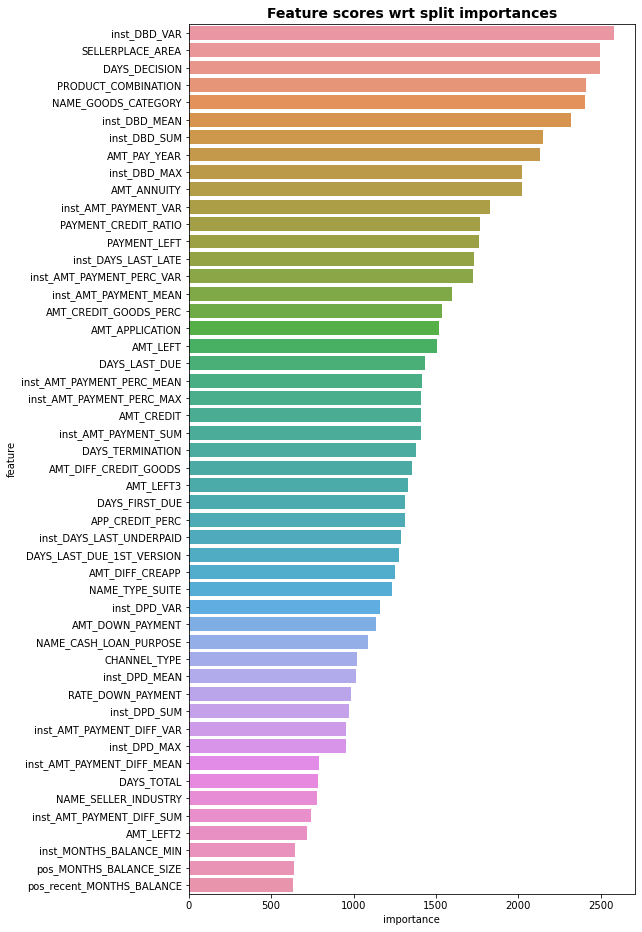

In [42]:
# Plot feature importances
feature_importance = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)

best_features = feature_importance.iloc[:50].reset_index()

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(8, 16))
gs = gridspec.GridSpec(1, 1)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='importance', y='feature', data=best_features, ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)